Importing libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import recall_score, precision_score, f1_score

Reading files

In [29]:
# Clase contains which type of tissue is each
X = pd.read_csv('datasets/dataset_tissue.txt', index_col = 0).T
y = pd.read_csv('datasets/clase.txt', index_col = 0)

There is no need of using pipelines in this case, so it is scaled the data as first step

In [30]:
X_sc = MinMaxScaler().fit_transform(X)

It has to be known the appropiate number of components which are employed to perform PCA algorythm

In [31]:
# declaring and pca instance
pca_all = PCA(n_components = X.shape[0], random_state = 23)

# fitting pipeline
pca_all.fit(X_sc)

PCA(n_components=189, random_state=23)

Plotting cumulative variance ratio

Number of components: 60


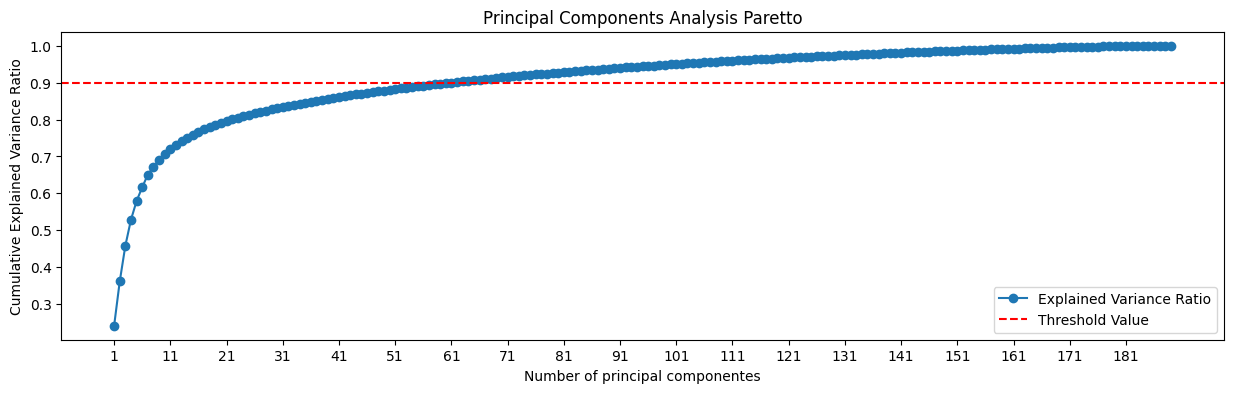

In [32]:
# getting cumulative variance
cum_variance = np.cumsum(pca_all.explained_variance_ratio_)

# choosing threshold
threshold = 0.90

# Calculating the selected number of components by using the chosen threshold
n_pca = len(cum_variance[cum_variance <= threshold])
print(f"Number of components: {n_pca}")

# defining plot
plt.figure(figsize = (15, 4))
plt.plot(cum_variance, '-o', label = 'Explained Variance Ratio')
plt.title('Principal Components Analysis Paretto')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xlabel('Number of principal componentes')
plt.xticks(range(0, X.shape[0], 10), range(1, X.shape[0] + 1, 10))
plt.axhline(threshold, c = 'red', label = 'Threshold Value', linestyle = '--')
plt.legend()
plt.show()


Then the new X dataset is fitted by using the found n_components

In [33]:
# declaring and pca instance
pca = PCA(n_components = n_pca, random_state = 23)

# fitting model
X_pca = pca.fit_transform(X_sc)

Applying Agglomerative Hierarchical Clustering on those selected principal components

In [34]:
# declaring hierarchical clustering instance
agg_clus = AgglomerativeClustering(n_clusters = None, distance_threshold = 0)

# fitting model
agg_clus.fit(X_pca)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

Defining function to plot dendrogram

In [35]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

Plotting dendrogram

Number of Unique Variables of each type: 7


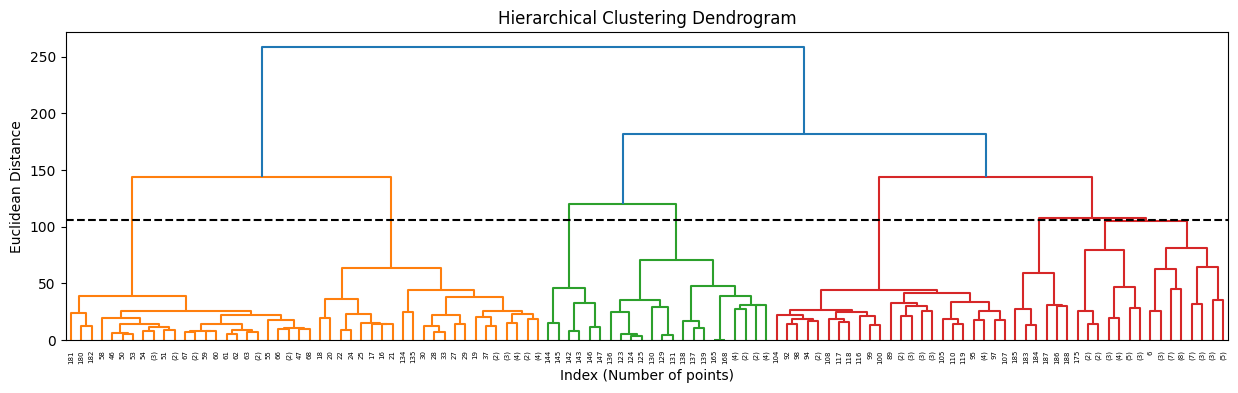

In [36]:
# defining plot
threshold_line_cut = 106
plt.figure(figsize = (15, 4))
top_n_levels_dendrogram = len(np.unique(y))
print(f"Number of Unique Variables of each type: {top_n_levels_dendrogram}")
plot_dendrogram(agg_clus, truncate_mode = 'level', p = top_n_levels_dendrogram)
plt.axhline(threshold_line_cut, c = 'black', linestyle = '--')
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Euclidean Distance')
plt.xlabel('Index (Number of points)')
plt.show()

It can be seen in the previous Figure, by cutting the Hierarchical Dendrogram at 106 Euclidian Distance, it is obtained 7 clusters which corresponds to the number of unique variable of "y" dataset. Now, a kind of elbow plot is made in order to verify these clusters

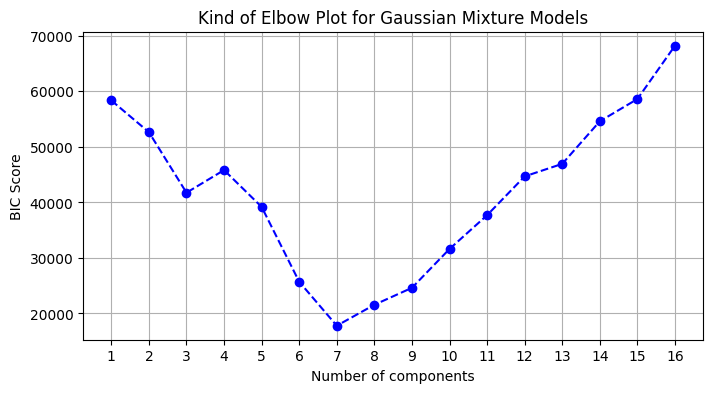

In [37]:
# declaring an empty list which stores each inertia per number of clusters
bic_scores = list()

# assigning maximum number of clusters
n_max_clusters = 16

# iterating the number of clusters in a mixture gaussian instance
for n_clusters in range(1, n_max_clusters + 1):
    # declaring and fitting gaussian mixture model
    gaussian_model = GaussianMixture(n_components = n_clusters, random_state = 23)
    gaussian_model.fit(X_pca)
    bic_scores.append(gaussian_model.bic(X_pca))

# plotting BIC Scores
plt.figure(figsize=(8, 4))
plt.plot(bic_scores, marker = 'o', linestyle = '--', color = 'b')
plt.xlabel('Number of components')
plt.xticks(range(0, n_max_clusters), range(1, n_max_clusters + 1))
plt.ylabel('BIC Score')
plt.title('Kind of Elbow Plot for Gaussian Mixture Models')
plt.grid(True)
plt.show()

As it can be observed in the plot, the lowest BIC score corresponds to a 15th-cluster-gaussian mixture model, this makes sense regarding the previous hierarchical plot, which showed below the threshold that there were more divisions that could have been made by deacreasing this value, nonetheless, a 7th-cluster-gaussian mixture model should be chosen because it would have been the lowest one if only it had been selected 7 clusters, and also because of the actual number of unique values "y" dataset has to be compared with. Thus, the following cell puts all of this together

In [38]:
# establishin number of components
n_components = 15

# declaring a 7th-cluster-gaussian model
gaussian_model = GaussianMixture(n_components = n_components, tol = 1e-6 ,max_iter = 300, init_params = 'k-means++', random_state = 23)

# fitting model
gaussian_model.fit(X_pca)

GaussianMixture(init_params='k-means++', max_iter=300, n_components=15,
                random_state=23, tol=1e-06)

Now it has been fitted, predictions need to be performed to get the labels the model has grouped

In [39]:
# getting labels
gaussian_labels = gaussian_model.predict(X_pca).astype(int)

In order to visualize how clusters were corresponded, another pca fit is done but this time only with 2 components to have x-y axis

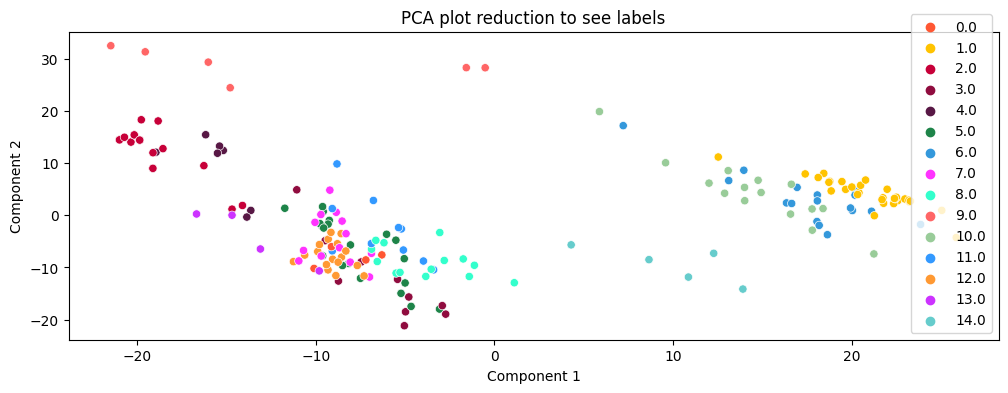

In [40]:
# declaring pca instance to use to plot
pca_plot = PCA(n_components = 2, random_state = 23)

# Creating the X_plot data set
X_plot = pca_plot.fit_transform(X_sc)
X_plot_gauss= np.c_[X_plot, gaussian_labels]

# ploting with sns
colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
            "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]

plt.figure(figsize = (12, 4))          
sns.scatterplot(x = X_plot_gauss[:, 0], y = X_plot_gauss[:, 1], hue = X_plot_gauss[:, 2], palette = colors[:n_components])
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title('PCA plot reduction to see labels')
plt.legend(loc = 'lower right')
plt.show()

Then it is compared to the actual "y" targets, as first step, a encoding transformation has to be performed before the comparison

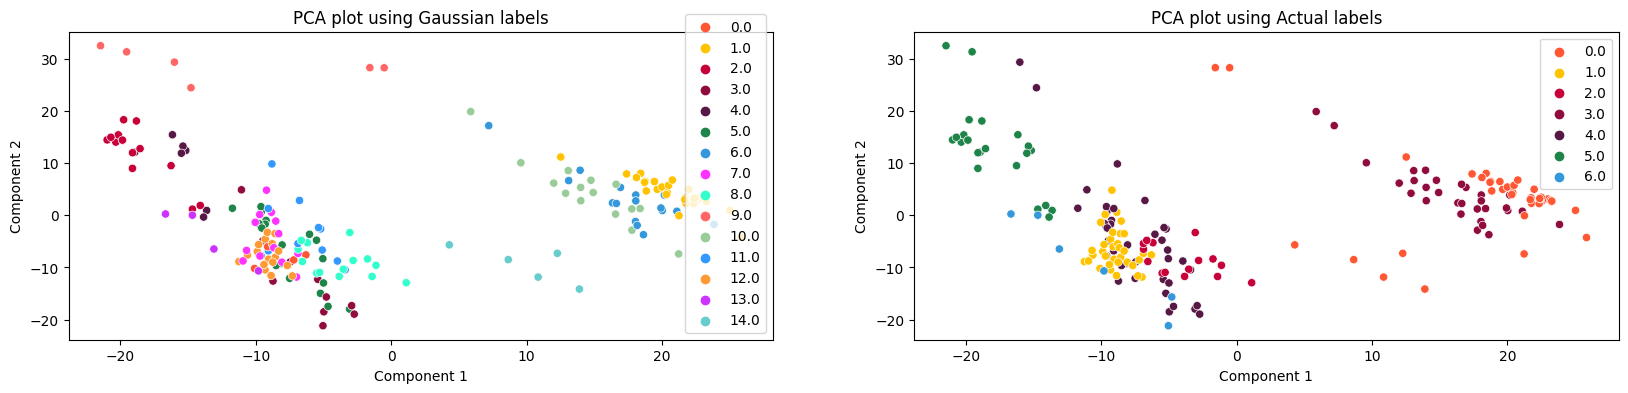

In [41]:
# changing unique values for numeric ones
y_label = np.zeros((len(y),1))
target_dict = dict()
for label, tissue_type in enumerate(np.unique(y)):
    y_label = np.where(y == tissue_type, label, y_label)
    target_dict[label] = tissue_type

y_label = y_label.ravel().astype(int)

# plotting one next to the other
X_plot_gauss = np.c_[X_plot, gaussian_labels]
X_plot_real = np.c_[X_plot, y_label]

fig, axis = plt.subplots(1, 2, figsize = (20, 4))
colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
            "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]

## first plot
sns.scatterplot(x = X_plot_gauss[:, 0], y = X_plot_gauss[:, 1], hue = X_plot_gauss[:, 2], palette = colors[:n_components], ax = axis[0])
axis[0].set_ylabel('Component 2')
axis[0].set_xlabel('Component 1')
axis[0].set_title('PCA plot using Gaussian labels')
axis[0].legend(loc = 'lower right')

## second plot
sns.scatterplot(x = X_plot_real[:, 0], y = X_plot_real[:, 1], hue = X_plot_real[:, 2], palette = colors[:7], ax = axis[1])
axis[1].set_ylabel('Component 2')
axis[1].set_xlabel('Component 1')
axis[1].set_title('PCA plot using Actual labels')
plt.show()

By looking at the plots, it can be appreciated some differences, and, based on the fact that class numbers have nothing to do with the gaussian labels inasmuch as the second ones were assigned during the fitting process without having actual labels information. Thus, a check cluster task is performed to visualize the most frequent actual label in each gaussian cluster

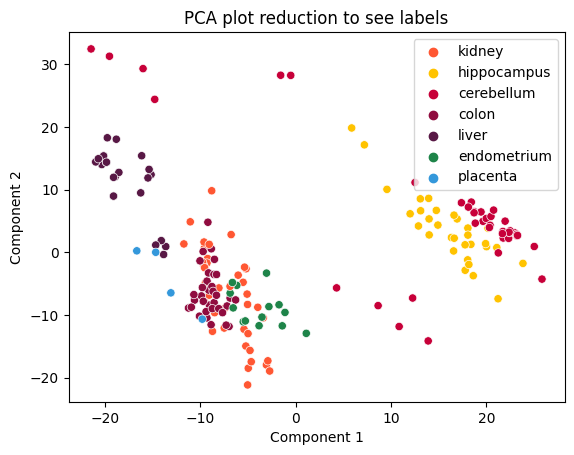

In [42]:
# Creating a dataframe with gaussian clusters and actual labels
base_information = {'gaussian_labels': gaussian_labels,
                    'actual_labels': y_label,
                    'label_name': y.to_numpy().ravel()}

data_clusters = pd.DataFrame(base_information)

# querying dataframe to verify most frequent label name per gaussian label
gaussian_dict = data_clusters.groupby('gaussian_labels').agg({'label_name': lambda x: x.mode().iloc[0]}).to_dict()['label_name']
data_clusters['predicted_label_name'] = data_clusters['gaussian_labels'].map(gaussian_dict) # predictions
n_unique_predicted = len(np.unique(data_clusters['predicted_label_name']))

# ploting with sns
colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
            "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]
            
sns.scatterplot(x = X_plot_gauss[:, 0], y = X_plot_gauss[:, 1], hue = data_clusters['predicted_label_name'], palette = colors[:n_unique_predicted])
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title('PCA plot reduction to see labels')
plt.legend(loc = 'upper right')
plt.show()

As it can be seen, the gaussian model cannot predict the placenta target by having as a prediction the most frequent class at each gaussian component, afterall, there are other methods to be performed. Now it is time to evaluate recall, precision and f1 score using macro average.

In [43]:
# getting actual values and predictions
y_actual = data_clusters.label_name
y_pred = data_clusters.predicted_label_name

# getting scores
recall_gauss = recall_score(y_actual, y_pred, average = 'macro', zero_division = 0)
precision_gauss = precision_score(y_actual, y_pred, average = 'macro', zero_division = 0)
f1_gauss = f1_score(y_actual, y_pred, average = 'macro', zero_division = 0)

# Showing metrics
print(f"Recall score: {recall_gauss:.4f}")
print(f"Precision score: {precision_gauss:.4f}")
print(f"F1 score: {f1_gauss:.4f}")

Recall score: 0.9208
Precision score: 0.9709
F1 score: 0.9404
